# CDL Match Prediction

Professional winner-prediction workflow using real results, CV model selection, walk-forward backtest, and forward picks.


## Data, Features, Training, Backtest

┌──────────────────────────────────────────────┐
│ MODEL DIAGNOSTICS: Scikit-Learn              │
├──────────────────────────────────────────────┤
│ K-Fold CV Accuracy: 66.8% (± 10.6%)         │
│ Walk-Forward Acc  : 62.7% over 67 matches  │
│ ROC-AUC Score     : 0.736                          │
│ Log Loss (Brier)  : 0.598                          │
└──────────────────────────────────────────────┘

STATISTICAL SUMMARY (statsmodels Logit)
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   82
Model:                          Logit   Df Residuals:                       76
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Feb 2026   Pseudo R-squ.:                  0.2373
Time:                        00:33:25   Log-Likelihood:                -43.278
converged:                       True   LL-Null:                       -56.740
Covar

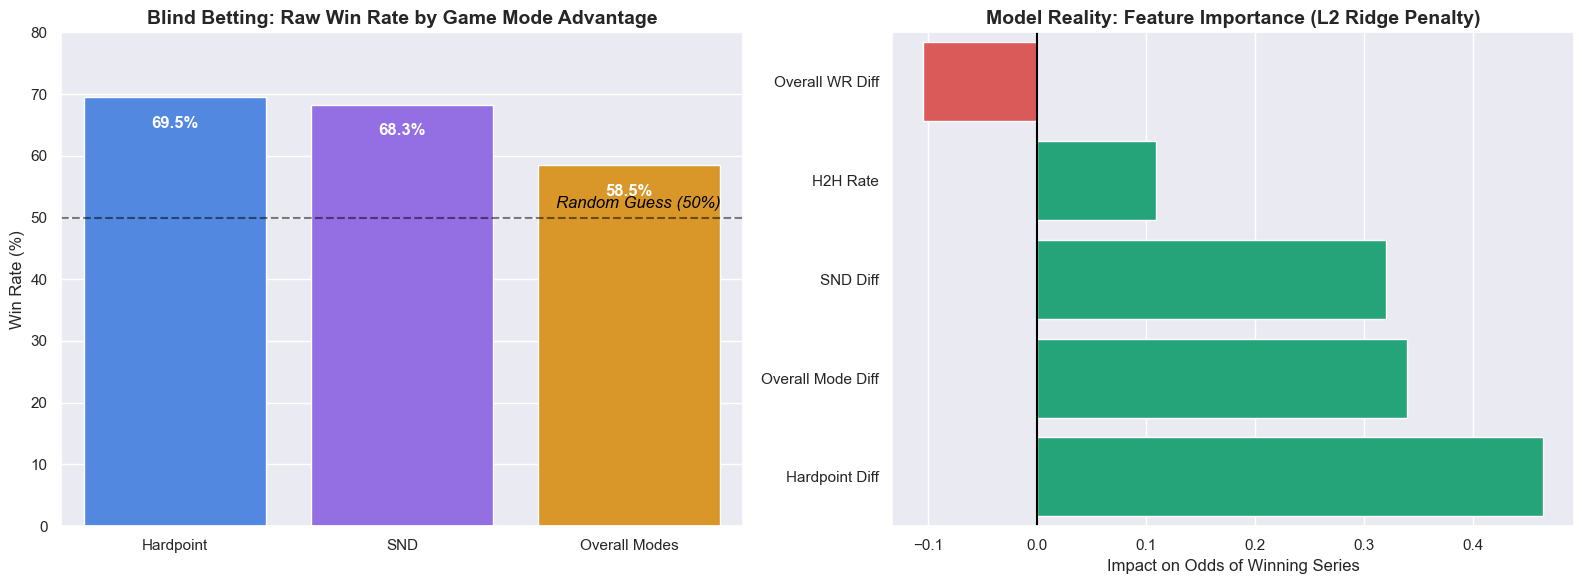

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score
import warnings
warnings.filterwarnings("ignore") # Mutes standard warnings for clean display

# Set visualization style
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

# ── Team name mapping ─────────────────────────────────────────────────────────
TEAM_CODE = {
    "OpTic Texas":           "TX",
    "FaZe Vegas":            "FV",
    "G2 Minnesota":          "MIN",
    "Paris Gentle Mates":    "M8",
    "Los Angeles Thieves":   "LAT",
    "Carolina Royal Ravens": "CAR",
    "Miami Heretics":        "MIA",
    "Boston Breach":         "BOS",
    "Riyadh Falcons":        "RYD",
    "Cloud9 New York":       "C9NY",
    "Toronto KOI":           "TOR",
    "Vancouver Surge":       "VAN",
}
CODE_TO_TEAM = {v: k for k, v in TEAM_CODE.items()}

# ── Load data ─────────────────────────────────────────────────────────────────
ts = (pd.read_csv("team_stats.csv")
        .assign(Team=lambda d: d["Team"].str.strip().map(CODE_TO_TEAM))
        .set_index("Team")
        .apply(pd.to_numeric, errors="coerce")
        .fillna(0))

matches = (pd.read_csv("match_results.csv")
             .assign(Date=lambda d: pd.to_datetime(d["Date"]),
                     Team_A=lambda d: d["Team_A"].str.strip(),
                     Team_B=lambda d: d["Team_B"].str.strip(),
                     Winner=lambda d: d["Winner"].str.strip())
             .sort_values("Date")
             .reset_index(drop=True))

MODE_COLS = {"HP": "HP_Win_Percent", "SND": "SND_Win_Percent", "OVL": "OVL_Win_Percent"}

# ── Helpers ───────────────────────────────────────────────────────────────────
def fresh_state():
    return {t: {"wins": 0, "games": 0} for t in ts.index}, {}

def mode_pct(team, mode):
    return float(ts.at[team, MODE_COLS[mode]]) / 100.0

def build_row(ta, tb, overall, h2h):
    a_wr  = overall[ta]["wins"] / overall[ta]["games"] if overall[ta]["games"] else 0.5
    b_wr  = overall[tb]["wins"] / overall[tb]["games"] if overall[tb]["games"] else 0.5
    a_h2h = h2h.get((ta, tb), 0)
    b_h2h = h2h.get((tb, ta), 0)
    total = a_h2h + b_h2h
    return {
        "wr_diff":  a_wr - b_wr,
        "h2h_rate": a_h2h / total if total else 0.5,
        "hp_diff":  mode_pct(ta, "HP")  - mode_pct(tb, "HP"),
        "snd_diff": mode_pct(ta, "SND") - mode_pct(tb, "SND"),
        "ovl_diff": mode_pct(ta, "OVL") - mode_pct(tb, "OVL"),
    }

def update_state(ta, tb, winner, overall, h2h):
    loser = tb if winner == ta else ta
    overall[ta]["games"] += 1
    overall[tb]["games"] += 1
    overall[winner]["wins"] += 1
    h2h[(winner, loser)] = h2h.get((winner, loser), 0) + 1

def valid_row(ta, tb, winner):
    return {ta, tb, winner} <= set(ts.index) and winner in (ta, tb)

# ── Build dataset (no leakage) ────────────────────────────────────────────────
overall, h2h = fresh_state()
X_rows, y = [], []

for _, r in matches.iterrows():
    ta, tb, winner = r["Team_A"], r["Team_B"], r["Winner"]
    if not valid_row(ta, tb, winner):
        continue
    X_rows.append(build_row(ta, tb, overall, h2h))
    y.append(1 if winner == ta else 0)
    update_state(ta, tb, winner, overall, h2h)

X_df         = pd.DataFrame(X_rows)
y            = np.array(y)
scaler_final = StandardScaler().fit(X_df)
X            = scaler_final.transform(X_df)

# ── 1. Scikit-Learn Pipeline (Predictions & Backtesting) ──────────────────────
# C=0.1 applies Ridge (L2) Regularization to handle HP/SND Multicollinearity
model  = LogisticRegression(C=0.1, max_iter=3000, random_state=42)

cv_acc = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(model, X, y, cv=cv_acc, scoring="accuracy")

cv_diag   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_prob_cv = cross_val_predict(model, X, y, cv=cv_diag, method="predict_proba")[:, 1]

model.fit(X, y)

# Walk-forward backtest
overall_wf, h2h_wf      = fresh_state()
X_hist, y_hist, correct = [], [], []
wf_model, wf_scaler     = None, StandardScaler()

for _, r in matches.iterrows():
    ta, tb, winner = r["Team_A"], r["Team_B"], r["Winner"]
    if not valid_row(ta, tb, winner):
        continue
    x = build_row(ta, tb, overall_wf, h2h_wf)
    if len(X_hist) >= 15 and len(set(y_hist)) > 1:
        if len(X_hist) % 5 == 0:
            wf_scaler = StandardScaler()
            wf_model  = clone(model)
            wf_model.fit(wf_scaler.fit_transform(pd.DataFrame(X_hist)), np.array(y_hist))
        if wf_model is not None:
            p    = float(wf_model.predict_proba(wf_scaler.transform(pd.DataFrame([x])))[0][1])
            pred = ta if p >= 0.5 else tb
            correct.append(pred == winner)
    X_hist.append(x)
    y_hist.append(1 if winner == ta else 0)
    update_state(ta, tb, winner, overall_wf, h2h_wf)

bt_acc = np.mean(correct) if correct else 0.0

# Diagnostic Outputs (Sklearn)
logloss = log_loss(y, y_prob_cv)
auc = roc_auc_score(y, y_prob_cv)

print(f"┌{'─'*46}┐")
print(f"│ MODEL DIAGNOSTICS: Scikit-Learn              │")
print(f"├{'─'*46}┤")
print(f"│ K-Fold CV Accuracy: {scores.mean():.1%} (± {scores.std():.1%})         │")
print(f"│ Walk-Forward Acc  : {bt_acc:.1%} over {len(correct):<2} matches  │")
print(f"│ ROC-AUC Score     : {auc:.3f}                          │")
print(f"│ Log Loss (Brier)  : {logloss:.3f}                          │")
print(f"└{'─'*46}┘\n")

# ── 2. Statsmodels Summary (P-values & Coefficients) ──────────────────────────
print("STATISTICAL SUMMARY (statsmodels Logit)\n" + "="*50)
X_sm = sm.add_constant(pd.DataFrame(X, columns=X_df.columns))

try:
    mod1 = sm.Logit(y, X_sm)
    result = mod1.fit(disp=0) 
    print(result.summary())
except Exception as e:
    print(f"Statsmodels fit failed: {e}")

# ── 3. Visualizations ─────────────────────────────────────────────────────────
print("\n" + "="*50 + "\nGENERATING VISUALIZATIONS...\n" + "="*50)

# VISUAL 1: Raw Win Rates (The Multicollinearity Illusion)
hp_wins = sum(1 for i, row in X_df.iterrows() if (row['hp_diff'] > 0 and y[i] == 1) or (row['hp_diff'] < 0 and y[i] == 0))
snd_wins = sum(1 for i, row in X_df.iterrows() if (row['snd_diff'] > 0 and y[i] == 1) or (row['snd_diff'] < 0 and y[i] == 0))
ovl_wins = sum(1 for i, row in X_df.iterrows() if (row['ovl_diff'] > 0 and y[i] == 1) or (row['ovl_diff'] < 0 and y[i] == 0))

win_rates = [hp_wins/len(y)*100, snd_wins/len(y)*100, ovl_wins/len(y)*100]
modes = ['Hardpoint', 'SND', 'Overall Modes']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=modes, y=win_rates, ax=ax1, palette=["#3b82f6", "#8b5cf6", "#f59e0b"])
ax1.axhline(50, ls='--', color='black', alpha=0.5)
ax1.text(2.4, 51, "Random Guess (50%)", va='bottom', ha='right', color='black', style='italic')
ax1.set_ylim(0, 80)
ax1.set_ylabel("Win Rate (%)")
ax1.set_title("Blind Betting: Raw Win Rate by Game Mode Advantage")
for i, v in enumerate(win_rates):
    ax1.text(i, v - 5, f"{v:.1f}%", color='white', ha='center', fontweight='bold', fontsize=12)

# VISUAL 2: Logistic Regression Feature Weights (Ridge)
coefs = pd.DataFrame({
    'Feature': ['Overall WR Diff', 'H2H Rate', 'Hardpoint Diff', 'SND Diff', 'Overall Mode Diff'],
    'Weight (Log-Odds)': model.coef_[0]
}).sort_values('Weight (Log-Odds)')

colors = ['#ef4444' if c < 0 else '#10b981' for c in coefs['Weight (Log-Odds)']]
sns.barplot(x='Weight (Log-Odds)', y='Feature', data=coefs, ax=ax2, palette=colors)
ax2.axvline(0, color='black', lw=1.5)
ax2.set_title("Model Reality: Feature Importance (L2 Ridge Penalty)")
ax2.set_xlabel("Impact on Odds of Winning Series")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

# ── Expose state variables for Block 2 (Predicting Future Matches) ────────────
OVERALL, H2H = overall, h2h


##  Predict & Display Upcoming Matchups

In [11]:
# ── Score distribution (BO5: HP, SND, OVL, HP, SND) ──────────────────────────
def bo5_dist(ta, tb):
    p_by_mode = {
        m: np.clip(mode_pct(ta, m) / (mode_pct(ta, m) + mode_pct(tb, m)), 0.1, 0.9)
        for m in ("HP", "SND", "OVL")
    }
    states = {(0, 0): 1.0}
    for m in MAP_ORDER:
        p, nxt = p_by_mode[m], {}
        for (a, b), pr in states.items():
            if a == 3 or b == 3:
                nxt[(a, b)] = nxt.get((a, b), 0.0) + pr
            else:
                nxt[(a+1, b)] = nxt.get((a+1, b), 0.0) + pr * p
                nxt[(a, b+1)] = nxt.get((a, b+1), 0.0) + pr * (1 - p)
        states = nxt
    return states

# ── Predict ───────────────────────────────────────────────────────────────────
def predict(ta, tb):
    row  = build_row(ta, tb, OVERALL, H2H)
    p_a  = float(model.predict_proba(scaler_final.transform(pd.DataFrame([row])))[0][1])
    win, lose, prob = (ta, tb, p_a) if p_a >= 0.5 else (tb, ta, 1 - p_a)
    dist = bo5_dist(ta, tb)

    win_keys  = [(a, b) for a, b in dist if (a == 3 and win == ta) or (b == 3 and win == tb)]
    best      = max(win_keys, key=lambda k: dist[k])

    # Score always shown as winner-loser
    if win == ta:
        score = f"{best[0]}-{best[1]}"
    else:
        score = f"{best[1]}-{best[0]}"

    return {
        "matchup":    f"{ta} vs {tb}",
        "winner":     win,
        "loser":      lose,
        "win_prob":   prob,
        "score":      score,
        "score_prob": dist[best],
        "hp_a":  mode_pct(ta, "HP"),  "hp_b":  mode_pct(tb, "HP"),
        "snd_a": mode_pct(ta, "SND"), "snd_b": mode_pct(tb, "SND"),
        "ovl_a": mode_pct(ta, "OVL"), "ovl_b": mode_pct(tb, "OVL"),
    }

# ── Upcoming matchups ─────────────────────────────────────────────────────────
matchups = [
    ("OpTic Texas",          "Boston Breach",          "Week 1"),
    ("Toronto KOI",          "Carolina Royal Ravens",  "Week 1"),
    ("Miami Heretics",       "FaZe Vegas",             "Week 1"),
    ("Riyadh Falcons",       "Paris Gentle Mates",     "Week 1"),
    ("OpTic Texas",          "G2 Minnesota",           "Week 1"),
    ("Toronto KOI",          "FaZe Vegas",             "Week 1"),
    ("Vancouver Surge",      "Los Angeles Thieves",    "Week 1"),
    ("Paris Gentle Mates",   "Miami Heretics",         "Week 1"),
    ("Riyadh Falcons",       "Boston Breach",          "Week 1"),
    ("Los Angeles Thieves",  "Carolina Royal Ravens",  "Week 1"),
    ("G2 Minnesota",         "Cloud9 New York",        "Week 1"),
    ("Vancouver Surge",      "FaZe Vegas",             "Week 2"),
    ("Riyadh Falcons",       "Cloud9 New York",        "Week 2"),
    ("Toronto KOI",          "Los Angeles Thieves",    "Week 2"),
    ("Toronto KOI",          "G2 Minnesota",           "Week 2"),
    ("Los Angeles Thieves",  "Boston Breach",          "Week 2"),
    ("Paris Gentle Mates",   "Carolina Royal Ravens",  "Week 2"),
    ("OpTic Texas",          "Miami Heretics",         "Week 2"),
    ("Riyadh Falcons",       "Carolina Royal Ravens",  "Week 2"),
    ("Vancouver Surge",      "Boston Breach",          "Week 2"),
    ("OpTic Texas",          "Cloud9 New York",        "Week 2"),
    ("G2 Minnesota",         "FaZe Vegas",             "Week 2"),
    ("Carolina Royal Ravens","Boston Breach",          "Week 3"),
    ("Riyadh Falcons",       "FaZe Vegas",             "Week 3"),
    ("Paris Gentle Mates",   "Cloud9 New York",        "Week 3"),
    ("Riyadh Falcons",       "G2 Minnesota",           "Week 3"),
    ("Toronto KOI",          "Miami Heretics",         "Week 3"),
    ("Vancouver Surge",      "Carolina Royal Ravens",  "Week 3"),
    ("OpTic Texas",          "Los Angeles Thieves",    "Week 3"),
    ("Toronto KOI",          "Paris Gentle Mates",     "Week 3"),
    ("FaZe Vegas",           "Boston Breach",          "Week 3"),
    ("Miami Heretics",       "Cloud9 New York",        "Week 3"),
    ("Vancouver Surge",      "OpTic Texas",            "Week 3"),
    ("Vancouver Surge",      "Cloud9 New York",        "Week 4"),
    ("Los Angeles Thieves",  "FaZe Vegas",             "Week 4"),
    ("Miami Heretics",       "G2 Minnesota",           "Week 4"),
    ("Paris Gentle Mates",   "G2 Minnesota",           "Week 4"),
    ("OpTic Texas",          "FaZe Vegas",             "Week 4"),
    ("Toronto KOI",          "Riyadh Falcons",         "Week 4"),
    ("Cloud9 New York",      "Boston Breach",          "Week 4"),
    ("Miami Heretics",       "Los Angeles Thieves",    "Week 4"),
    ("Toronto KOI",          "Boston Breach",          "Week 4"),
    ("OpTic Texas",          "Carolina Royal Ravens",  "Week 4"),
    ("Vancouver Surge",      "Paris Gentle Mates",     "Week 4"),
    ("Toronto KOI",          "Cloud9 New York",        "Week 5"),
    ("Riyadh Falcons",       "Miami Heretics",         "Week 5"),
    ("Paris Gentle Mates",   "OpTic Texas",            "Week 5"),
    ("G2 Minnesota",         "Carolina Royal Ravens",  "Week 5"),
    ("Vancouver Surge",      "Toronto KOI",            "Week 5"),
    ("Los Angeles Thieves",  "Cloud9 New York",        "Week 5"),
]

# ── Build results ─────────────────────────────────────────────────────────────
pred_rows = []
for ta, tb, week in matchups:
    r  = predict(ta, tb)
    hp, snd, ovl = (r["hp_a"], r["snd_a"], r["ovl_a"]) if r["winner"] == ta else (r["hp_b"], r["snd_b"], r["ovl_b"])
    pred_rows.append({
        "Week":       week,
        "Matchup":    r["matchup"],
        "Winner":     r["winner"],
        "Score":      r["score"],
        "Score %":    f"{r['score_prob']:.0%}",
        "Win %":      f"{r['win_prob']:.0%}",
        "HP":         f"{hp:.0%}",
        "SND":        f"{snd:.0%}",
        "OVL":        f"{ovl:.0%}",
    })

# ── Display with week headers ─────────────────────────────────────────────────
display_rows, header_indices = [], []
for week in ["Week 1", "Week 2", "Week 3", "Week 4", "Week 5"]:
    header_indices.append(len(display_rows))
    # Restate headers on the Week row instead of leaving them blank
    display_rows.append({
        "Matchup": week, 
        "Winner": "Winner", 
        "Score": "Score",
        "Score %": "Score %", 
        "Win %": "Win %", 
        "HP": "HP", 
        "SND": "SND", 
        "OVL": "OVL"
    })
    for r in pred_rows:
        if r["Week"] == week:
            display_rows.append({k: v for k, v in r.items() if k != "Week"})

display_df = pd.DataFrame(display_rows)

def style_table(df, header_indices):
    # Hide the standard pandas column headers completely since we inject them manually
    styles = [
        {"selector": "thead", "props": [("display", "none")]}, 
        {"selector": "td", "props": [("text-align", "center")]}
    ]
    
    def row_style(row):
        if row.name in header_indices:
            # Style the injected Week rows to look exactly like headers
            return ["background-color: #2c2c2c; color: white; font-weight: bold; text-align: center; border-top: 2px solid white;"] * len(row)
        return [""] * len(row)
        
    return df.style.hide(axis="index").set_table_styles(styles).apply(row_style, axis=1)

style_table(display_df, header_indices)


Matchup,Winner,Score,Score %,Win %,HP,SND,OVL
Week 1,Winner,Score,Score %,Win %,HP,SND,OVL
OpTic Texas vs Boston Breach,OpTic Texas,3-1,27%,83%,61%,63%,75%
Toronto KOI vs Carolina Royal Ravens,Carolina Royal Ravens,3-2,25%,56%,33%,53%,46%
Miami Heretics vs FaZe Vegas,FaZe Vegas,3-1,21%,58%,56%,56%,65%
Riyadh Falcons vs Paris Gentle Mates,Paris Gentle Mates,3-1,23%,63%,77%,62%,44%
OpTic Texas vs G2 Minnesota,OpTic Texas,3-1,22%,71%,61%,63%,75%
Toronto KOI vs FaZe Vegas,FaZe Vegas,3-1,24%,75%,56%,56%,65%
Vancouver Surge vs Los Angeles Thieves,Los Angeles Thieves,3-0,32%,88%,60%,56%,57%
Paris Gentle Mates vs Miami Heretics,Paris Gentle Mates,3-1,25%,70%,77%,62%,44%
Riyadh Falcons vs Boston Breach,Riyadh Falcons,3-1,25%,66%,54%,47%,57%


## Prediction Distribution


In [ ]:
valid = df["Win %"].str.strip() != ""
winner_counts = df.loc[valid, "Winner"].value_counts().sort_values(ascending=True)
fig1, ax1 = plt.subplots(figsize=(8, 6))
bars = ax1.barh(winner_counts.index, winner_counts.values, color="steelblue", edgecolor="navy", alpha=0.85)
ax1.set_xlabel("Predicted Match Wins")
ax1.set_title("Upcoming Predictions By Team")
ax1.set_xlim(0, winner_counts.max() + 1)
for b in bars:
    ax1.text(b.get_width() + 0.1, b.get_y() + b.get_height()/2, f"{int(b.get_width())}", va="center", fontsize=9)
ax1.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

